# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                           
Sample_027  A0A286YFE3;A0A286YFF7;A0A286YFL8;A0A2C9F2P4;P50897;Q5T0S4   15.124
Sample_142  G3V295;G3V3I1;G3V5Z7;P60900                                 12.905
Sample_153  O75882;O75882-2;O75882-3                                    17.925
Sample_160  A0A087WZR4                                                  15.859
Sample_072  P61278                                                      19.388
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_188  Q7L0X0           16.298
Sample_154  E9PEX6;P09622    15.602
Sample_054  G3XAK1;P26927    15.467
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.806
            A0A075B6Q5                 12.739
            A0A075B6R2                 11.135
            A0A075B6S5                 12.653
            A0A087WSY4                 12.989
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.817
            Q9UI40;Q9UI40-2            12.380
            Q9UIW2                     12.674
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.300
            Q9UP79                     11.759
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.844,15.050,16.842,19.863,16.392,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.350,19.067,...,15.528,15.576,14.494,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.714,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.891,17.705,17.039,16.286,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.418,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.697,15.345,17.084,18.708,14.249,19.433,11.864,11.180
Sample_207,15.739,16.877,15.469,16.898,14.651,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.500,12.473,13.030,13.483,13.395,12.895,13.455,13.792,13.989,13.023
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.220,19.067,16.127,...,13.138,13.447,13.473,13.381,12.421,13.669,12.566,12.752,13.050,13.300
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.401,13.267,11.995,11.707,13.173,12.833,11.794,12.544,12.403,14.155
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.025,13.198,12.658,12.555,12.676,12.575,12.881,12.833,12.449,12.906
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.515,10.868,12.378,12.496,13.237,13.590,12.937,13.492,13.472,12.438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.096,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 327.73it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.21it/s]

100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.79it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.10it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.74it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.37it/s]

100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.51it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.48it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 10.25it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.25it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.54it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.45it/s]

100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.00it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.10it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.39it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.12it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.13it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.36it/s]

100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

100%|██████████| 8/8 [00:02<00:00,  3.89it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.84it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.02it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.81it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.55it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.44it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.46it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.13it/s]

100%|██████████| 9/9 [00:01<00:00,  4.24it/s]

100%|██████████| 9/9 [00:01<00:00,  4.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.03it/s]

 30%|███       | 3/10 [00:00<00:01,  5.75it/s]

 40%|████      | 4/10 [00:00<00:01,  4.51it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.25it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.20it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.41it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.13it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.90it/s]

100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.57it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.70it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.68it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.59it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.52it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.57it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.77it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.67it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.82it/s]

100%|██████████| 11/11 [00:02<00:00,  4.16it/s]

100%|██████████| 11/11 [00:02<00:00,  4.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.20it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.60it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.82it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.55it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.31it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.35it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.28it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.82it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.93it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.07it/s]

100%|██████████| 12/12 [00:02<00:00,  4.08it/s]

100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.40it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.29it/s]

 31%|███       | 4/13 [00:00<00:01,  5.32it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.14it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.13it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.25it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.25it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.34it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.46it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.04it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.94it/s]

100%|██████████| 13/13 [00:02<00:00,  4.09it/s]

100%|██████████| 13/13 [00:02<00:00,  4.38it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.13it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.57it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.58it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.16it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.42it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.10it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.08it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  3.98it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.87it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.34it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.47it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.54it/s]

100%|██████████| 14/14 [00:03<00:00,  3.27it/s]

100%|██████████| 14/14 [00:03<00:00,  3.96it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.35it/s]

 20%|██        | 3/15 [00:00<00:01,  6.05it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.60it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.43it/s]

 40%|████      | 6/15 [00:01<00:02,  4.37it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.45it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.43it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.21it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.19it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.94it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.01it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.07it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.21it/s]

100%|██████████| 15/15 [00:03<00:00,  4.21it/s]

100%|██████████| 15/15 [00:03<00:00,  4.43it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.049 0.019          0.581 0.447       0.078   
2             0.004 0.003      0.045 0.015          0.752 0.090       0.683   
3             0.005 0.005      0.058 0.022          0.742 0.095       0.668   
4             0.006 0.005      0.057 0.024          0.744 0.100       0.667   
5             0.005 0.004      0.046 0.021          0.727 0.112       0.684   
6             0.005 0.004      0.049 0.019          0.776 0.094       0.793   
7             0.007 0.006      0.056 0.024          0.772 0.098       0.787   
8             0.004 0.002      0.038 0.011          0.778 0.094       0.793   
9             0.003 0.000      0.034 0.005          0.780 0.093       0.791   
10            0.004 0.003      0.039 0.007          0.782 0.090       0.802   
11            0.004 0.002      0.037 0.009          0.811 0.080       0.818   
12            0.003 0.000      0.037 0.012          0.801 0.084       0.806   
13            0.004 0.002      0.037 0.009          0.804 0.088       0.789   
14            0.004 0.002      0.038 0.009          0.798 0.084       0.787   
15            0.004 0.001      0.035 0.008          0.801 0.091       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.132 0.126                  0.533 0.038        0.840   
2          0.102   0.709 0.068                  0.756 0.053        0.839   
3          0.108   0.696 0.074                  0.745 0.057        0.834   
4          0.106   0.695 0.072                  0.745 0.055        0.831   
5          0.102   0.697 0.079                  0.743 0.064        0.834   
6          0.110   0.778 0.075                  0.810 0.061        0.894   
7          0.112   0.773 0.078                  0.805 0.065        0.892   
8          0.107   0.780 0.073                  0.811 0.063        0.894   
9          0.106   0.780 0.074                  0.811 0.063        0.892   
10         0.107   0.786 0.073                  0.817 0.062        0.892   
11         0.097   0.811 0.066                  0.838 0.058        0.905   
12         0.098   0.799 0.069                  0.828 0.058        0.904   
13         0.095   0.792 0.068                  0.822 0.057        0.903   
14         0.095   0.788 0.068                  0.819 0.057        0.901   
15         0.093   0.794 0.069                  0.823 0.059        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.806 0.083        210.000 0.000  
2          0.057                  0.779 0.088        210.000 0.000  
3          0.058                  0.772 0.089        210.000 0.000  
4          0.058                  0.771 0.089        210.000 0.000  
5          0.060                  0.777 0.082        210.000 0.000  
6          0.047                  0.876 0.054        210.000 0.000  
7          0.047                  0.873 0.055        210.000 0.000  
8          0.048                  0.874 0.055        210.000 0.000  
9          0.048                  0.870 0.055        210.000 0.000  
10         0.047                  0.870 0.054        210.000 0.000  
11         0.046                  0.883 0.057        210.000 0.000  
12         0.047                  0.886 0.055        210.000 0.000  
13         0.049                  0.886 0.055        210.000 0.000  
14         0.049                  0.884 0.055        210.000 0.000  
15         0.050                  0.892 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 485.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.37it/s]

100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.18it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

100%|██████████| 4/4 [00:00<00:00,  4.28it/s]

100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.30it/s]

 60%|██████    | 3/5 [00:00<00:00,  7.01it/s]

 80%|████████  | 4/5 [00:00<00:00,  6.11it/s]

100%|██████████| 5/5 [00:00<00:00,  5.49it/s]

100%|██████████| 5/5 [00:00<00:00,  6.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  9.07it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.66it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.95it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.87it/s]

100%|██████████| 6/6 [00:01<00:00,  4.83it/s]

100%|██████████| 6/6 [00:01<00:00,  5.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.91it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.59it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.18it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.13it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.98it/s]

100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.83it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.84it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.99it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.67it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.49it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.51it/s]

100%|██████████| 8/8 [00:01<00:00,  4.27it/s]

100%|██████████| 8/8 [00:01<00:00,  4.69it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 10.71it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.56it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.16it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.36it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.72it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.69it/s]

100%|██████████| 9/9 [00:01<00:00,  4.75it/s]

100%|██████████| 9/9 [00:01<00:00,  5.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.68it/s]

 30%|███       | 3/10 [00:00<00:01,  6.23it/s]

 40%|████      | 4/10 [00:00<00:01,  5.98it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.17it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.95it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.38it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.10it/s]

 90%|█████████ | 9/10 [00:01<00:00,  3.88it/s]

100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.91it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.15it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.86it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.93it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.59it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.30it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.17it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.39it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.69it/s]

100%|██████████| 11/11 [00:02<00:00,  4.71it/s]

100%|██████████| 11/11 [00:02<00:00,  4.73it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.19it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.63it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.96it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.94it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  7.03it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  7.13it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.90it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.60it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.60it/s]

100%|██████████| 12/12 [00:01<00:00,  6.50it/s]

100%|██████████| 12/12 [00:01<00:00,  6.95it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.71it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.40it/s]

 31%|███       | 4/13 [00:00<00:01,  5.14it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.46it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.41it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.31it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.22it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.21it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.29it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.45it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.40it/s]

100%|██████████| 13/13 [00:02<00:00,  4.37it/s]

100%|██████████| 13/13 [00:02<00:00,  4.59it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.33it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.14it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.48it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.77it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.56it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.25it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.20it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.25it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.05it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.91it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.07it/s]

100%|██████████| 14/14 [00:02<00:00,  6.19it/s]

100%|██████████| 14/14 [00:02<00:00,  6.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.74it/s]

 20%|██        | 3/15 [00:00<00:01,  6.95it/s]

 27%|██▋       | 4/15 [00:00<00:01,  6.26it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.99it/s]

 40%|████      | 6/15 [00:00<00:01,  5.82it/s]

 47%|████▋     | 7/15 [00:01<00:01,  5.46it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.24it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.55it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.52it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.80it/s]

 80%|████████  | 12/15 [00:02<00:00,  6.11it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  6.42it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.32it/s]

100%|██████████| 15/15 [00:02<00:00,  6.43it/s]

100%|██████████| 15/15 [00:02<00:00,  6.09it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.052 0.017          0.073 0.234       0.007   
2             0.005 0.005      0.057 0.026          0.620 0.126       0.448   
3             0.004 0.005      0.047 0.019          0.812 0.078       0.724   
4             0.004 0.002      0.037 0.013          0.807 0.083       0.726   
5             0.003 0.001      0.032 0.005          0.802 0.088       0.720   
6             0.004 0.001      0.035 0.007          0.803 0.088       0.746   
7             0.003 0.000      0.033 0.003          0.858 0.083       0.792   
8             0.003 0.001      0.028 0.006          0.848 0.086       0.793   
9             0.003 0.002      0.031 0.005          0.850 0.086       0.788   
10            0.003 0.000      0.030 0.006          0.831 0.088       0.782   
11            0.003 0.000      0.029 0.005          0.831 0.091       0.790   
12            0.002 0.001      0.023 0.004          0.848 0.084       0.809   
13            0.002 0.001      0.023 0.006          0.856 0.084       0.802   
14            0.002 0.000      0.021 0.005          0.850 0.084       0.803   
15            0.002 0.000      0.020 0.004          0.837 0.088       0.803   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.023   0.013 0.040                  0.499 0.011        0.863   
2          0.127   0.513 0.115                  0.623 0.075        0.713   
3          0.101   0.760 0.070                  0.799 0.052        0.882   
4          0.109   0.758 0.070                  0.797 0.054        0.887   
5          0.118   0.752 0.078                  0.793 0.060        0.887   
6          0.113   0.767 0.076                  0.804 0.059        0.889   
7          0.103   0.818 0.066                  0.846 0.053        0.917   
8          0.096   0.815 0.066                  0.843 0.054        0.914   
9          0.101   0.813 0.071                  0.841 0.058        0.913   
10         0.116   0.800 0.079                  0.831 0.065        0.916   
11         0.115   0.804 0.076                  0.834 0.062        0.916   
12         0.102   0.823 0.069                  0.850 0.057        0.925   
13         0.105   0.822 0.070                  0.849 0.057        0.925   
14         0.107   0.820 0.070                  0.848 0.056        0.925   
15         0.097   0.814 0.066                  0.842 0.054        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.833 0.087        210.000 0.000  
2          0.085                  0.654 0.102        210.000 0.000  
3          0.048                  0.853 0.058        210.000 0.000  
4          0.045                  0.857 0.056        210.000 0.000  
5          0.046                  0.857 0.057        210.000 0.000  
6          0.047                  0.863 0.057        210.000 0.000  
7          0.044                  0.895 0.057        210.000 0.000  
8          0.044                  0.892 0.057        210.000 0.000  
9          0.045                  0.891 0.057        210.000 0.000  
10         0.043                  0.894 0.053        210.000 0.000  
11         0.044                  0.894 0.056        210.000 0.000  
12         0.042                  0.905 0.052        210.000 0.000  
13         0.042                  0.906 0.051        210.000 0.000  
14         0.041                  0.906 0.049        210.000 0.000  
15         0.041                  0.906 0.048 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1419.87it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 47.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 40.77it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 43.81it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 35.86it/s]

100%|██████████| 5/5 [00:00<00:00, 35.70it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 38.00it/s]

100%|██████████| 6/6 [00:00<00:00, 31.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 39.10it/s]

100%|██████████| 7/7 [00:00<00:00, 35.12it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 31.55it/s]

100%|██████████| 8/8 [00:00<00:00, 26.92it/s]

100%|██████████| 8/8 [00:00<00:00, 27.47it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 40.24it/s]

100%|██████████| 9/9 [00:00<00:00, 35.62it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 41.29it/s]

100%|██████████| 10/10 [00:00<00:00, 35.58it/s]

100%|██████████| 10/10 [00:00<00:00, 36.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 33.63it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 31.23it/s]

100%|██████████| 11/11 [00:00<00:00, 30.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 31.78it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 29.14it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 29.08it/s]

100%|██████████| 12/12 [00:00<00:00, 29.47it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 42.53it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 33.23it/s]

100%|██████████| 13/13 [00:00<00:00, 32.78it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 42.14it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 34.05it/s]

100%|██████████| 14/14 [00:00<00:00, 29.34it/s]

100%|██████████| 14/14 [00:00<00:00, 31.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 35.96it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 29.74it/s]

 80%|████████  | 12/15 [00:00<00:00, 30.02it/s]

100%|██████████| 15/15 [00:00<00:00, 30.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.001          0.000 0.000       0.000   
2             0.002 0.001      0.019 0.003          0.576 0.121       0.407   
3             0.002 0.000      0.020 0.002          0.635 0.112       0.518   
4             0.002 0.001      0.021 0.004          0.646 0.104       0.557   
5             0.002 0.001      0.021 0.006          0.664 0.093       0.568   
6             0.002 0.001      0.022 0.005          0.701 0.104       0.599   
7             0.002 0.000      0.019 0.002          0.677 0.091       0.599   
8             0.002 0.000      0.021 0.003          0.706 0.088       0.648   
9             0.002 0.000      0.021 0.003          0.719 0.079       0.654   
10            0.002 0.000      0.020 0.002          0.714 0.079       0.656   
11            0.003 0.002      0.024 0.004          0.712 0.088       0.644   
12            0.002 0.000      0.020 0.002          0.703 0.086       0.641   
13            0.003 0.001      0.024 0.005          0.699 0.091       0.630   
14            0.003 0.001      0.021 0.004          0.689 0.090       0.614   
15            0.002 0.001      0.021 0.002          0.688 0.091       0.611   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.719   
2          0.078   0.472 0.078                  0.589 0.060        0.683   
3          0.118   0.564 0.099                  0.649 0.069        0.744   
4          0.110   0.593 0.096                  0.666 0.071        0.756   
5          0.107   0.608 0.090                  0.679 0.067        0.783   
6          0.115   0.641 0.095                  0.705 0.074        0.800   
7          0.118   0.630 0.092                  0.695 0.066        0.810   
8          0.113   0.670 0.081                  0.723 0.062        0.818   
9          0.113   0.679 0.081                  0.733 0.062        0.819   
10         0.115   0.678 0.083                  0.731 0.062        0.818   
11         0.121   0.670 0.086                  0.725 0.065        0.814   
12         0.124   0.664 0.090                  0.721 0.067        0.811   
13         0.127   0.656 0.095                  0.715 0.070        0.808   
14         0.121   0.643 0.092                  0.705 0.068        0.803   
15         0.120   0.642 0.091                  0.704 0.067        0.802   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.664 0.082        210.000 0.000  
2          0.078                  0.632 0.090        210.000 0.000  
3          0.073                  0.670 0.091        210.000 0.000  
4          0.072                  0.693 0.086        210.000 0.000  
5          0.066                  0.716 0.083        210.000 0.000  
6          0.063                  0.733 0.077        210.000 0.000  
7          0.061                  0.749 0.078        210.000 0.000  
8          0.059                  0.753 0.079        210.000 0.000  
9          0.059                  0.756 0.078        210.000 0.000  
10         0.058                  0.752 0.077        210.000 0.000  
11         0.061                  0.753 0.079        210.000 0.000  
12         0.061                  0.748 0.079        210.000 0.000  
13         0.064                  0.747 0.082        210.000 0.000  
14         0.062                  0.742 0.081        210.000 0.000  
15         0.063                  0.739 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,1,11
score_time,3,2,13
test_precision,11,7,9
test_recall,11,12,10
test_f1,11,12,9
test_balanced_accuracy,11,12,9
test_roc_auc,11,14,9
test_average_precision,15,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 13.46it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.71it/s]

 36%|███▌      | 5/14 [00:00<00:01,  8.05it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.71it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.25it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  7.31it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.21it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.23it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.89it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.59it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.48it/s]

100%|██████████| 14/14 [00:01<00:00,  6.72it/s]

100%|██████████| 14/14 [00:01<00:00,  7.28it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 39.71it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 32.73it/s]

100%|██████████| 9/9 [00:00<00:00, 33.42it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 14.58it/s]

 36%|███▋      | 4/11 [00:00<00:00,  9.89it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  8.65it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  8.66it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.48it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  8.35it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.13it/s]

100%|██████████| 11/11 [00:01<00:00,  8.23it/s]

100%|██████████| 11/11 [00:01<00:00,  8.70it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


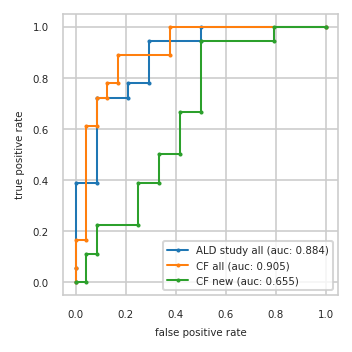

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.389  0.000 0.167  0.042 0.111
3          0.083 0.389  0.042 0.167  0.083 0.111
4          0.083 0.722  0.042 0.611  0.083 0.222
5          0.208 0.722  0.083 0.611  0.250 0.222
6          0.208 0.778  0.083 0.722  0.250 0.389
7          0.292 0.778  0.125 0.722  0.333 0.389
8          0.292 0.944  0.125 0.778  0.333 0.500
9          0.500 0.944  0.167 0.778  0.417 0.500
10         0.500 1.000  0.167 0.889  0.417 0.667
11         1.000 1.000  0.375 0.889  0.500 0.667
12           NaN   NaN  0.375 1.000  0.500 0.944
13           NaN   NaN  1.000 1.000  0.792 0.944
14           NaN   NaN    NaN   NaN  0.792 1.000
15           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,P31321
1,Q9NRN5,P22676,O60565
2,P09486,A6NNI4;G8JLH6;P21926,E9PK25;G3V1A4;P23528
3,P22676,Q9Y2T3;Q9Y2T3-3,Q96GD0
4,P10636-2;P10636-6,P61981,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
5,P14174,P04075,P51688
6,P61981,P14174,Q14894
7,Q9Y2T3;Q9Y2T3-3,P15151-2,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,P00338;P00338-3,P25189;P25189-2,Q9NUQ9


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


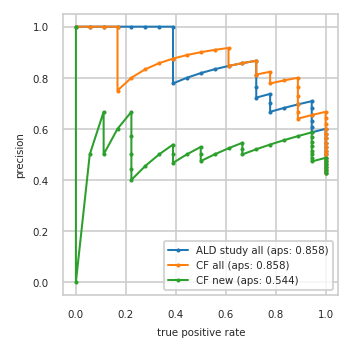

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.586 0.944     0.621 1.000     0.586 0.944
14         0.607 0.944     0.643 1.000     0.571 0.889
15         0.630 0.944     0.667 1.000     0.556 0.833
16         0.654 0.944     0.654 0.944     0.538 0.778
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.708 0.944     0.667 0.889     0.500 0.667
19         0.696 0.889     0.696 0.889     0.522 0.667
20         0.682 0.833     0.727 0.889     0.545 0.667
21         0.667 0.778     0.762 0.889     0.524 0.611
22         0.700 0.778     0.800 0.889     0.500 0.556
23         0.737 0.778     0.789 0.833     0.474 0.500
24         0.722 0.722     0.778 0.778     0.500 0.500
25         0.765 0.722     0.824 0.778     0.529 0.500
26         0.812 0.722     0.812 0.722     0.500 0.444
27         0.867 0.722     0.867 0.722     0.467 0.389
28         0.857 0.667     0.857 0.667     0.500 0.389
29         0.846 0.611     0.846 0.611     0.538 0.389
30         0.833 0.556     0.917 0.611     0.500 0.333
31         0.818 0.500     0.909 0.556     0.455 0.278
32         0.800 0.444     0.900 0.500     0.400 0.222
33         0.778 0.389     0.889 0.444     0.444 0.222
34         0.875 0.389     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


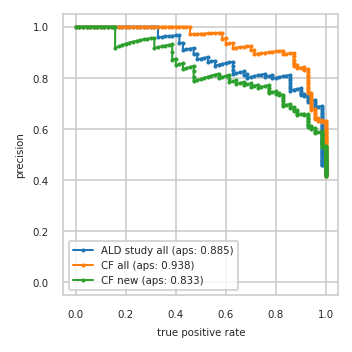

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


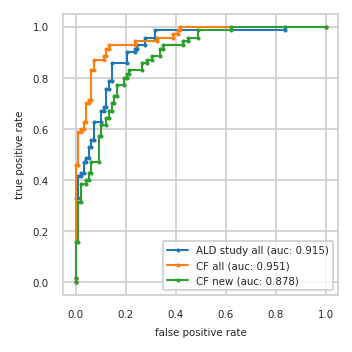

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}